<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tfidf" data-toc-modified-id="tfidf-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tfidf</a></span></li><li><span><a href="#spherical-kmeans" data-toc-modified-id="spherical-kmeans-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>spherical kmeans</a></span><ul class="toc-item"><li><span><a href="#title-확인" data-toc-modified-id="title-확인-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>title 확인</a></span></li><li><span><a href="#날짜로-먼저-클러스터링" data-toc-modified-id="날짜로-먼저-클러스터링-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>날짜로 먼저 클러스터링</a></span><ul class="toc-item"><li><span><a href="#날짜에-따른-뉴스-빈도-확인" data-toc-modified-id="날짜에-따른-뉴스-빈도-확인-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>날짜에 따른 뉴스 빈도 확인</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime
import re

import tensorflow as tf
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from coclust.clustering import SphericalKmeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
with open('data/tokenized.pickle', 'rb') as file:
    tfidf = pickle.load(file)

In [3]:
def get_dataframe(data_name_with_route):
    ## load news data
    with open(data_name_with_route, 'rb') as file:
        data_list = []
        while True:
            try:
                data = pickle.load(file)
            except EOFError:
                break
            data_list.append(data)
    ## construct lists for dataframe
    title = []
    content = []
    date = []
    for news in data_list[0]['return_object']['documents']: 
        title.append(news['title'])
        content.append(news['content'])
        date.append(news['published_at'][:10]) #### 시간 조정이 필요하면 바꾸기
    ## make lists as dataframe
    news_data = pd.DataFrame([])
    news_data['date'] = date
    news_data['title'] = title
    news_data['content'] = content
    return news_data

In [4]:
data_son = get_dataframe('data/rawdata_손흥민.pickle')
data_kbl = get_dataframe('data/rawdata_프로농구.pickle')

In [5]:
data_son['label'] = 0
data_kbl['label'] = 1
data = pd.concat([data_son,data_kbl])
data.reset_index(inplace = True)
data.drop(['index'],axis = 1,inplace = True)

In [6]:
reg_reporter = re.compile('[가-힣]+\s[가-힣]*기자') # 기자
reg_email = re.compile('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$') # 이메일
reg_eng = re.compile('[a-z]+') # 소문자 알파벳, 이메일 제거용, 대문자는 남겨둔다
reg_chi = re.compile("[\u4e00-\u9fff]+") # 한자
reg_sc = re.compile("\W+") # 특수문자
reg_date = re.compile('\d*일|\d*월|\d*년|\d*시|\d*분|\(현지시간\)|\(현지시각\)|\d+') #날짜,시간,숫자

In [7]:
def preProcessing(doc):
    tmp = re.sub(reg_reporter, '', doc)
    tmp = re.sub(reg_email, '', tmp)
    tmp = re.sub(reg_eng, '', tmp)
    tmp = re.sub(reg_chi, '', tmp)
    tmp = re.sub(reg_sc, ' ', tmp)
    tmp = re.sub(reg_date, '', tmp)
    return tmp

In [8]:
data['content_re'] = data['content'].apply(preProcessing)

## tfidf

In [38]:
df_news = pd.read_csv('삼성.csv',encoding = 'utf-8-sig')

In [39]:
df_news['tokenized']

0       ['아웃카운트', '개', '못', '선발', '승', '불발', '두산', '임'...
1       ['현재', '유한', '세대', '통신', '스마트폰', '갤럭', '를', '판...
2       ['백승', '숙', '별세', '김태영', '채널', '씨', '모친상', '오후...
3       ['법원', '발부', '구속영장', '기한', '종료', '기결', '수로', '...
4       ['삼성', '구자욱', '은', '지난', '대구', '전', '좌완', '금민철...
5       ['뇨', '사장', '부산', '공장', '르노', '한국', '장서', '경쟁력...
6       ['중국', '광저우', '기업인', '만난', '적', '중국', '간', '신발...
7       ['서밋', '코엑스', '린다', '서밋', '아마존', '웹서비스', '자사',...
8       ['선발', '못', '강판', '경기', '최', '폭투', '개', '불명예',...
9       ['진주', '아파트', '방화', '살해', '혐의', '안모', '씨', '오후...
10      ['노', '씨', '별세', '이춘', '홍씨', '화천', '정교회', '장로'...
11      ['글로벌', '스포츠', '기업', '젠', '스포츠', '이하', '젠', '대...
12      ['라이선스', '사용', '료', '쟁', '끝', '퀄컴', '모뎀', '칩',...
13      ['지난', '비메', '모리', '힘', '못', '한국', '위태', '반도체'...
14      ['페이', '로', '간편', '결제', '이용', '금액', '지난해', '배'...
15      ['김금', '씨', '별세', '최승환', '재혁', '동반성', '위원회', '...
16      ['나훈아', '노래', '속', '잡초', '이름', '꽃', '향기도', '손'...
17      ['이영자'

In [41]:
tmp = df_news['tokenized']

In [44]:
obj_tfidf = TfidfVectorizer()
x = obj_tfidf.fit_transform(tmp)

In [45]:
len(obj_tfidf.get_feature_names())

32296

## spherical kmeans

* n_cluster = 5 일때 다른 주제의 기사들이 섞여있음
* n_cluster = 10 으로 테스트

In [63]:
sk = SphericalKmeans(n_clusters=10, max_iter = 40)

In [64]:
sk.fit(x)

 == New init == 
iteration: 0
592.3301354235616
iteration: 1
801.2977948459398
iteration: 2
910.7899834579933
iteration: 3
946.989434819485
iteration: 4
961.0174112376158
iteration: 5
971.9316729335768
iteration: 6
980.4788134204667
iteration: 7
989.8376815779253
iteration: 8
996.1222493768975
iteration: 9
999.338863702096
iteration: 10
1001.7259656181883
iteration: 11
1003.7344220424332
iteration: 12
1004.7791580670759
iteration: 13
1005.1640988734531
iteration: 14
1005.349040080004
iteration: 15
1005.493480041486
iteration: 16
1005.5271144244999
iteration: 17


In [65]:
df_news['labels'] = pd.Series(sk.labels_)

### title 확인

In [66]:
df_news[df_news['labels']==0]['title'] # 투자, 횡령? 

11                       “윌 스미스도 투자”…e스포츠 기업 ‘젠지’ 521억 유치
27                               빈폴키즈, 키즈플랫폼 ‘꾸럭’ 프로모션 전개
35               '명품의 메카' 청담 상점 5곳 중 1곳 공실...명품 매장 철수가 원인
43                          제약산업 수출지원 성과… 3곳서 1분기 183억 계약
56                     삼성 QLED TV, 유럽서 호평 세례… 역대 최고점 갈아치워
61                         섹시한 ‘허당’… 유인나, 데뷔 10년만에 ‘광고 퀸’
62                               삼성전자 QLED TV, 유럽서 호평 이어져
69                    삼성메디코스, 원진바이오에이치씨와 화장품 개발·생산 ODM 계약
84                              금융자산 30억 고객에 가업 승계 全과정 지원
85                김부장 月407만원, 박대리 月110만원… 노후준비 빠를수록 부담 줄어
86                           펀드 1위 운용사 대표 "주가 올해 2600 간다"
92                               LPG차 일반 시판 허용 후… 판매 쾌속질주
94        강력 바람, 서큘레이터에 실어 빠르게 전달 ‘무풍 냉방’ 모드로 최대 90% 절전한다
97                    “채권은 시간 사는 것… 잘 분산된 펀드투자 뒤 당분간 잊어야”
126                                 승리 ‘버닝썬 자금 횡령’ 의혹도 수사
130                  르베이지, 나점수 작가 협업 프로젝트 전개…주요 매장서 작품 전시
157                   삼성전자서비스센터, 평일 오후 7시, 토요일 오후 1시까지 운영
158           

In [67]:
df_news[df_news['labels']==1]['title'] # 5G 

1                       5G폰 출시 앞둔 화웨이 "최고 속도"... 삼성 정조준
12                      5G 다급해진 애플, 퀄컴과 ‘30조원 소송’ 전격 합의
31                      애플, 퀄컴과 화해 ‘5G폰 급시동’…삼성과 대결 본격화
33                  증권가 "코스피, 한 달 정도 더 상승"...연간 전망은 엇갈려
34                      [마켓뷰] "중국 경기부양 끝나나"…연속상승 끝낸 코스피
37                    한경연 "작년 법인세 부담, 정부 전망보다 두배 이상 늘어"
40                             이화공영 삼성제약주식회사와 86억원 계약체결
49                   안 터지는 5G, 속 터지는 이용자 "동의하셨는데요 고객님?"
50                        애플-퀄컴 5G 위기감에 ‘30조 특허戰’ 극적 종결
53                              인텔 "스마트폰용 5G 모뎀칩 개발 포기"
57                 5G 급한 애플, 퀄컴과 합의하자 인텔은 “5G 모뎀 포기” 선언
60                  5G가 '30조 특허 전쟁' 말렸다…애플이 퀄컴에 백기 든 이유
64                    애플은 5G 아이폰 급했다···퀄컴과 30조 소송 접은 까닭
65                        14거래일 연속상승 도전하는 코스피, 장초반 강보합세
67                      “2018년 법인세 인상부담 정부 추정치의 2배 넘는다”
76                                   세계 최초 5G 상용화 ‘후유증’
82                              에이즈·인플루엔자·간염을 무릎꿇린 이 회사
100                   화웨이 “5G 클라우드 준비” 삼성 “5G 통신

In [69]:
df_news[df_news['labels']==2]['title'] # 부고, 부음

2                                     [부고]백승숙씨 별세 外
5                            르노삼성 CEO “한국 투자 계속할 것”
6                                   [설왕설래] 임금인상의 역습
10                                   [부고] 노갑수씨 별세 외
15                            오늘의 부고 - 2019년 4월 18일
17                                      4월 18일 궂긴소식
30         오거돈 시장 만난 르노삼성 사장 “부산공장은 핵심 자원 떠나지 않을 것”
42                      [부고] 전수신(전 삼성라이온즈 대표이사)씨 별세
54      시뇨라 르노삼성 사장, 부산시장 만나 지속 투자 약속…“파업에도 품질 이상無”
55                    시뇨라 르노삼성 사장 “한국 시장에 투자 계속될 것”
66                      시뇨라 르노삼성 사장 “韓 시장 투자 지속할 것”
78               [사설] 툭하면 공공청사 불법 진입·농성… ‘민노총 나라’인가
96                 [사설]르노삼성 노조, 셧다운 넘어 공장 폐업 자초할 건가
105                [사설] “노사 현실 직시하라” 르노삼성 임원의 사임 편지
109               [2018 삼성화재배 월드바둑마스터스] 무너져내리는 탕웨이싱
188                                            [부고]
192                           [부음] 김연갑 흥진건설 대표 별세 외
194         "노사 갈등 계속되면 존립 악영향"… 르노삼성 창사 멤버의 '손 편지'
200                          [부고]김연갑 별세·민직 병직 부친상 外
201         

In [70]:
df_news[df_news['labels']==3]['title'] # 주가ㅡ 

75                두 항공사 수난에도 주가 훨훨… 시장 과열에 개미들 피해 우려
142                     아시아나항공, 최대주주 매각 소식에 이틀 연속 급등
146                           세대 교체 일어나는 항공…주가는 '훨훨'
156                         아시아나항공 주가 상승…“주가 변동성 확대”
180                           항공 오너가는 수난, 주식 투자자는 환호
184       [비즈톡톡] '스트리밍 전쟁' 시대 전세계가 안티...넷플릭스 제국 계속될까
216            서울모터쇼에서 이목을 끈 전기차, ‘EV 트렌드 코리아’로 이어진다
250     [소년중앙] 자율주행차 타보고 수소전기차 뜯어보고 미래 대세 자동차 확인한 시간
312        [미리보는 상하이모터쇼] 상하이에서 만날 수 있는 EV SUV와 크로스오버
356                            덜 위험한 ‘저변동성 주식’에 투자하라
392                       KT ‘포스트 황창규’ 차기회장 선임 절차 개시
435                    배당금 32兆 최대라는데… 내 통장엔 돈이 안들어오네
437                             몸값 1000만원 낮춘 전기車 충전중
543                              강남 대종빌딩 정밀안전진단 ‘최하’
554                    '붕괴 위험' 강남 대종빌딩, 정밀안전진단도 최하등급
559                       삼성동 대종빌딩 안전진단 최하등급… 재건축 가닥
583                    ‘붕괴위험’ 서울 삼성동 대종빌딩…안전등급 최하 판정
649            대종빌딩 허물고 다시 짓나?…기둥·벽체에 균열, 안전 ‘최하’ 등급
651               '붕괴위험' 강남 대종빌딩…정밀안전진단서 최하 'E

In [71]:
df_news[df_news['labels']==4]['title'] # 조양호 회장 별세

90                회현동서 일하세요? 월급 652만원, 제일 많이 받네요
129                 [한겨레 프리즘] 회장님의 수상한 퇴직금 / 최하얀
167                 사망·퇴진·건강악화…올 ‘재벌총수 지정’ 변동 클듯
186         대우건설 무리한 인수 후 그룹 휘청… ‘박삼구 오판’이 禍 불렀다
187                文대통령 우즈베크 국빈방문… 300명 경제사절단 동행
228                          [유레카] ‘재벌 총수’ 바통 터치
231            궈타이밍 폭스콘 회장, 사임 계획 밝혀…“중요 결정엔 관여”
239                "좋으신 분"…정의선·구광모·손학규 등 故조양호 조문
241                   구광모 LG 회장, 故양호 한진 회장 빈소 찾아
248              [특징주] 아시아나 관심집중…인수후보 기업, 일제히 폭등
254                     조양호 회장 장례 나흘째…각계각층 조문 계속
259              정의선·현정은·구자열·허창수…재계, 조양호 회장 추모행렬
267                 직원 늘리고 연봉 올리고…"중견건설사 살 맛 나네"
271            조양호 빈소 찾은 김연아가 한 말… 삼성 이재용 표정(영상)
272              김무성 "조양호 회장 별세 안타까워…적폐 수사 중단돼야"
282             “항공계 별 애도합니다”… 김연아 등 각계각층 줄잇는 조문
297     “민간외교 헌신 국가발전 큰 역할”… 조양호 회장 빈소 1700명 다녀가
303                     항공업계 ‘큰 별’ 추모하는 조문행렬 이어져
309                 故 조양호 회장 빈소 사흘째에도 조문객 행렬 이어져
313                 “대미관계서 인맥 지원… 국위선양 큰 역할 하셨다”
330               10

In [72]:
df_news[df_news['labels']==5]['title'] # AWS. ?

7                         [AWS 서밋 2019] 클라우드는 혁신 위한 원동력
9                               국가가 방치한 ‘묻지마 살인’ [뉴스분석]
13                     [기자메모]‘비메모리 반도체’ 26년 몸담은 기업인의 외침
19               ‘묻지마 살인’ …진주 아파트 방화·흉기 난동 5명 사망 [뉴스분석]
22                                        [포토] 안내견 체험보행
23            AWS "있는 그대로 저장, 이제는 클라우드 기반 '데이터 레이크' 시대"
24            아마존웹서비스 "클라우드 먹통 사태 후 데이터 지역별 분산 저장 강화했다"
25             세종대 ‘ICT 미래인재포럼 2019’에 VR 원천기술 등 연구성과 소개
28                   통합암학회 최낙원 이사장, "융합 암치료 최신 연구결과" 발표
39                                      대한소아심장학회 차기 이사장
45                          포스코, ‘기업시민’ 경영이념으로 내세운 까닭은?
46          [단독] 5나노 발표날 기흥 찾아온 인텔 GPU 수장...삼성서 위탁생산할 듯
48                                       [포토] ‘눈송아 환영해’
51                            <문화논단>멀지만 ‘가까워지는 나라’ 모잠비크
58                        반도체 슈퍼호황에도 팹리스 절반 중국에 밀려 '적자'
70               진주 아파트서 40대 男 방화·흉기 난동…12세 여아 등 18명 사상
71                  진주 아파트서 화재 후 묻지마 범죄 발생…어린이 포함 5명 숨져
74                       [알립니다] 남산 길 걸으며 광주수영대회 

In [74]:
df_news[df_news['labels']==6]['title'] # 야구

0                              공황장애 극복한 홍상삼, 폭투 5개에 눈물
4                          "공이 안 날아가요” 타고투저 깨는 공인구의 역습
8                         팀은 이겼지만…홍상삼 ‘폭투 트라우마’에 고개 떨궈
18                               ‘팀 타율 1위’ 한화 이글스의 엇박자
38          <베이스볼 스펙트럼>한정판 기념품 받고 사진 찍고… 스타와 즐기는 ‘굿데이’
59               ‘맥과이어·레일리·터너·다익손 아직 0승’ 린드블럼·켈리 벌써 3승
63           ‘평균자책점 0.26인데 고작 2승’ 윌슨, 지난해 이어 ‘불운한 투수?’
68                           타점 1위 키움 장영석 "순위표는 안 봅니다"
79                        선제 투런포… '2년차 징크스' 모르는 KT 강백호
104                ‘같은 평균자책점 0점’ 조상우-정우람 “우린 왜 이리 다를까”
106                     웃을 수도 울 수도 없는 삼성… 맥과이어 5이닝 2실점
107                      박병호 빠져도 강한 키움… 장영석 2안타·2타점 활약
113                             안우진 ‘괴물投’… 삼성전 7이닝 무실점
116                        LG 박용택, 프로야구 최초 2,400안타 금자탑
122                              두산, 한국시리즈 리턴매치 SK에 설욕
123                              [베이스볼 라운지]요즘 투수들의 성장법
179     ‘이승엽보다 3살 빨리 달성한 1000타점 -5’ 최정, 1498타점 돌파 시기는?
199                              [오늘의 경기/4월 16일]프로야구 外
293       

In [75]:
df_news[df_news['labels']==7]['title'] # 갤럭시 폴드

20                    출시 전 '갤럭시 폴드' 선물 받고 블랙핑크 멤버들이 보인 반응
21                       출시 안 된 갤럭시 폴드 사용 인증샷 남긴 슈퍼 얼리어답터
26                    블루라이트 줄인 갤럭시폴드 OLED...'아이컴포트' 인증 받아
32                           두바이 왕자, 출시 열흘 전 삼성 갤럭시폴드로 셀카
80                          두께 17㎜·무게 263g ‘갤럭시 폴드’ 스펙 공개
89                                    접으면 4.6인치 펼치면 7.3인치
99                          갤럭시 폴드, 접으면 두께 17mm… 무게는 263g
111                                 미 언론 “갤 폴드 사용 느낌 좋았다”
115                   삼성전자 ‘갤럭시 폴드’ 스펙 공개… 두께 17㎜·무게 263g
117                              갤럭시 폴드 두께는 17mm…상세 스펙 공개
118                              화웨이 5G 폴더블폰 ‘메이트X’ 7월 출시
124                                ‘갤 폴드’ 메이트X보다 두껍지만 가볍다
140                     "갤럭시 폴드, 접는 자국 선명···힌지쪽엔 1.5㎜ 틈새"
144                    삼성 갤럭시 폴드, 무게와 두께 공개… 화웨이 제품보다 가벼워
153                    가볍게 접히는 ‘갤럭시폴드 5G’… ‘메이트X’보다 32g ↓
164                     삼성 갤럭시 폴드 ‘두께 17㎜, 무게 263g’ 스펙 공개
168                            삼성전자, 국내 출시 '갤럭시 폴드' 사양 공개
169           

In [76]:
df_news[df_news['labels']==8]['title'] # k 리그, 프로배구

16                                       [기자칼럼]잡초의 힘
36         성남 중1구역 재개발 '신흥역 하늘채 랜더스원' 1000가구 내달 일반분양
73                   서울 집값 하락세 주춤… "바닥 찍었다" "일시적 현상"
77                    밥 먹듯 골 먹던 노동건, 이젠 골 잘막는 '예스'동건
102                               강남-마포-용산도 거래한파 못피해
103                            [오늘의 경기/4월 17일]프로야구 外
110                        ‘군에서 온 그대’ 이대헌, 전자랜드 책임진다
121                     권순찬 감독, KB손해보험과 재계약… 3년째 지휘봉
166                    삼성물산, 서울 삼성동 ‘래미안 라클래시’ 5월 분양
170                    겸재와 이중섭 사이… 잊고 있던 구한말 미술을 한눈에
189                            전통과 현대 넘나든 근대 서화가들의 붓
206                      100년 전 경복궁 그림…광화문을 감싼 새벽 봄볕
251         안중식의 '백악춘호''영광풍경'..근대 서화 걸작 100점 한자리에...
260      '조선의 끝, 근대의 시작' 알린 '낀세대' 화가 안중식 등 근대서화가 이야기
262               삼성물산 건설부문, 부산시민공원서 ‘래미안 플로깅 데이’ 진행
283               프로야구 90경기 만에 100만 관중… 일등공신은 창원NC파크
304                     울산 호랑이 11경기 무패 포효… 리그 단독 선두로
318                     '김인성 2골' 프로축구 울산, 인천 꺾고 선두탈환
343                      서울 아파트 가격 0.04%↓…재건축 

In [77]:
df_news[df_news['labels']==9]['title'] # 동탄->수서 srt,근혜누나?

3                     “불에 데고 살을 베는 통증” 박근혜 측, 형 집행정지 신청
14                       “○○페이로 결제할게요”… 간편결제 2년새 3배 급성장
29                           카드결제 위협하나… 간편결제 2년 새 3배 성장
41                     'MB사위' 이상주, 장인 재판 불출석…내달 10일로 연기
44                      오충진이 몰빵투자한 OCI 고위임원은 서울고법 부장 출신
47                           보험판매 수수료 인하·분납 정책에 뿔난 설계사들
52                            온라인 간편결제 선두…스마일>네이버>로켓페이순
72                     'MB 사위' 이상주, 장인 재판 출석…뇌물 전달 증언할까
81                      기결수 된 박근혜 前 대통령…교도소 이송·노역 투입 안해
83                             이마트 트레이더스 인기상품 최대 20% 할인
125                 자유한국당 이미선 ‘주식 의혹’ 고발 사건, 서울남부지검에 배당
131                              이부진-임우재, 이혼소송 항소심도 비공개
132               이부진-임우재 이혼 재판, 비공개로 한다…"선량한 풍속 해칠 우려"
133                  박근혜 전 대통령 이젠 기결수 신분…노역 않고 복장만 바뀔 듯
136              '김학의 사건'서도 등장한 '업무수첩'…이번에도 '검찰의 구원투수'?
171              박근혜 오늘 구속 만료…대법원, 이재용 부회장 등 선고 25일 가능성
173                    ‘국정농단’ 박근혜, 오늘밤 구속 기간 만료…기결수로 전환
174                    박근혜 구속 기간 만료 불구 석방 없다…미결수

### 날짜로 먼저 클러스터링

In [78]:
# n_cluster = 10으로해도 잡다한 기사가 섞여있다.
# 너무 주제가 많은 듯
# 날짜로 먼저 클러스터링 해놓고 그 안에서 주제를 갈라야 하지 않을까 싶다

In [79]:
df_news.head()

,news_id,title,content,date,content_pp,tokenized,title_pp,tokenized_title,labels
0,1.101101e+06,"공황장애 극복한 홍상삼, 폭투 5개에 눈물",아웃카운트 1개 못 잡아 714일 만의 선발승 불발\n\n\n\n두산의 임시 선발 ...,2019-04-18T05:04:49.000+09:00,아웃카운트 1개 못 잡아 만의 선발승 불발 두산의 임 선발 홍상삼 29 이 만에...,"['아웃카운트', '개', '못', '선발', '승', '불발', '두산', '임'...",공황장애 극복한 홍상삼 폭투 5개에 눈물,"['공황장애', '극복', '홍상삼', '폭투', '개', '눈물']",6
1,1.101101e+06,"5G폰 출시 앞둔 화웨이 ""최고 속도""... 삼성 정조준",현재 유일한 5세대(G) 통신 스마트폰 ‘갤럭시S10 5G’를 판매하고 있는 삼성전...,2019-04-18T05:04:45.000+09:00,현재 유한 5세대 G 통신 스마트폰 갤럭S10 5G 를 판매하고 있는 삼성전자는 ...,"['현재', '유한', '세대', '통신', '스마트폰', '갤럭', '를', '판...",5G폰 출 앞둔 화웨이 최고 속도 삼성 정조준,"['폰', '화웨이', '최고', '속도', '삼성', '정', '조준']",1
2,1.101101e+06,[부고]백승숙씨 별세 外,▲백승숙씨 별세ㆍ김태영(채널A 대전충청취재본부 기자)씨 모친상=17일 오후5시 충남...,2019-04-18T05:04:34.000+09:00,백승숙씨 별세 김태영 채널A 씨 모친상 오후 충남대병원 발인 낮 042 280...,"['백승', '숙', '별세', '김태영', '채널', '씨', '모친상', '오후...",부고 백승숙씨 별세,"['부고', '백승', '숙', '별세']",2
3,1.101101e+06,"“불에 데고 살을 베는 통증” 박근혜 측, 형 집행정지 신청",법원에서 발부한 구속영장 기한이 종료돼 기결수로 신분이 전환된 박근혜 전 대통령 측...,2019-04-18T05:03:42.000+09:00,법원에서 발부한 구속영장 기한이 종료돼 기결수로 신이 전환된 박근혜 전 대통령 측이...,"['법원', '발부', '구속영장', '기한', '종료', '기결', '수로', '...",불에 데고 살을 베는 통증 박근혜 측 형 집행정지 신청,"['불', '데', '살', '통증', '박근혜', '형', '집행정지', '신청']",9
4,1.101101e+06,"""공이 안 날아가요” 타고투저 깨는 공인구의 역습",삼성 구자욱(26)은 지난 12일 대구 KT전에서 좌완 금민철을 상대로 가운데 담장...,2019-04-18T05:03:30.000+09:00,삼성 구자욱 26 은 지난 대구 KT전에서 좌완 금민철을 상대로 가운데 담장을 향...,"['삼성', '구자욱', '은', '지난', '대구', '전', '좌완', '금민철...",공이 안 날아가요 타고투저 깨는 공인구의 역습,"['공이', '안', '고투', '인구', '역습']",6


In [81]:
df_news['day'] = df_news['date'].apply(lambda date : date.split('T')[0])
df_news['time'] = df_news['date'].apply(lambda date : date.split('T')[1][:8])

In [83]:
df_news['day'] # 2019-02-28 ~ 2019-04-18

0       2019-04-18
1       2019-04-18
2       2019-04-18
3       2019-04-18
4       2019-04-18
5       2019-04-18
6       2019-04-17
7       2019-04-17
8       2019-04-17
9       2019-04-17
10      2019-04-17
11      2019-04-17
12      2019-04-17
13      2019-04-17
14      2019-04-17
15      2019-04-17
16      2019-04-17
17      2019-04-17
18      2019-04-17
19      2019-04-17
20      2019-04-17
21      2019-04-17
22      2019-04-17
23      2019-04-17
24      2019-04-18
25      2019-04-17
26      2019-04-17
27      2019-04-17
28      2019-04-17
29      2019-04-17
           ...    
4970    2019-02-28
4971    2019-02-28
4972    2019-02-28
4973    2019-02-28
4974    2019-02-27
4975    2019-02-27
4976    2019-02-27
4977    2019-02-27
4978    2019-02-27
4979    2019-02-27
4980    2019-02-27
4981    2019-02-27
4982    2019-02-27
4983    2019-02-27
4984    2019-02-27
4985    2019-02-27
4986    2019-02-27
4987    2019-02-27
4988    2019-02-27
4989    2019-02-27
4990    2019-02-27
4991    2019

####  날짜에 따른 뉴스 빈도 확인

In [94]:
day_count = df_news.groupby(['day'])['news_id'].count().reset_index()

In [100]:
day_count.shape # 51

(51, 2)

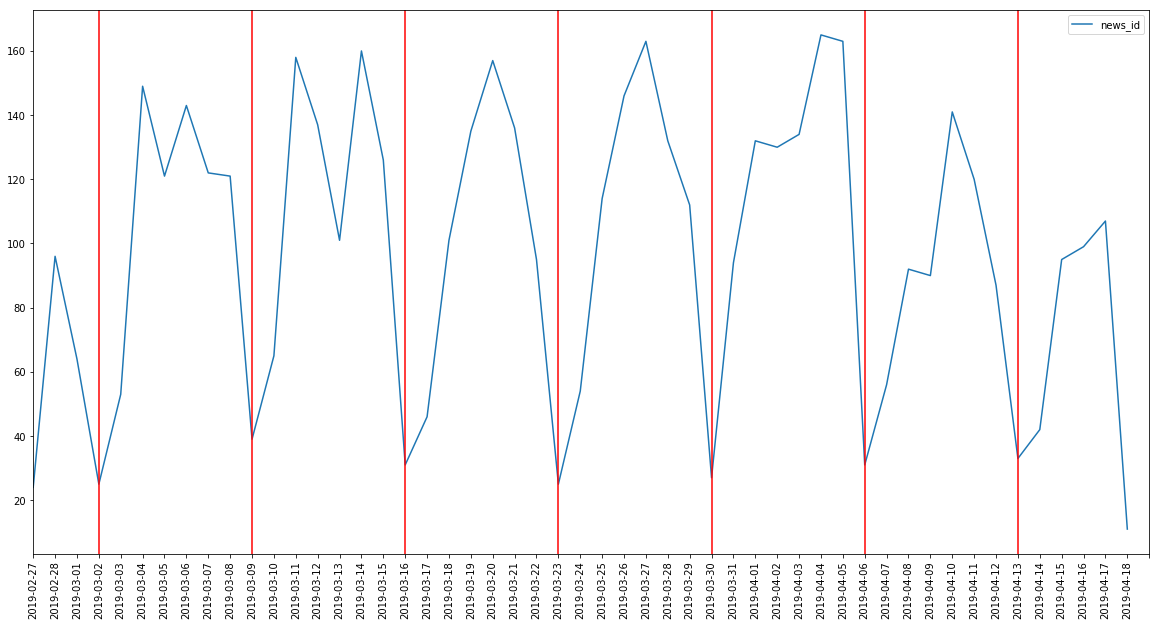

In [147]:
fig,ax = plt.subplots(1,1,figsize= (20,10))
day_count.plot(ax=ax)
plt.xticks(np.arange(52), labels = day_count.iloc[:,0].values.tolist(),rotation = 90 )
plt.axvline(x =3, color = 'red')
plt.axvline(x =10, color = 'red')
plt.axvline(x =17, color = 'red')
plt.axvline(x =24, color = 'red')
plt.axvline(x =31, color = 'red')
plt.axvline(x =38, color = 'red')
plt.axvline(x =45, color = 'red')

plt.show()

In [155]:
def timeGroup(date):
    label = 0
    if (('2019-02-27'<=date) | ('2019-03-02'>=date)) : label = 0

True

In [153]:
df_news['day'][3]

'2019-04-18'

In [157]:
df_news['day'][3]

'2019-04-18'